In [2]:
import pandas as pd
import numpy as np
from datasets import Dataset
import itertools
from datasets import load_dataset
from sentence_transformers import SentenceTransformer , SentenceTransformerTrainer
from sentence_transformers.losses import CachedMultipleNegativesRankingLoss ,ContrastiveLoss, OnlineContrastiveLoss
import os
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
import torch
# Imports
import pandas as pd
from datasets import load_dataset , Dataset
from transformers import AutoModelForCausalLM , RobertaTokenizer , RobertaForSequenceClassification , TrainingArguments, Trainer,TrainerCallback,AutoModelForSequenceClassification,AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import torch
import numpy as np
import torch.nn as nn
import numpy as np
from datasets import Dataset, Features, Value,Sequence
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

def evaluate(y_true ,y_pred ): 
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')#
    precision = precision_score(y_true, y_pred, average='weighted')#
    recall = recall_score(y_true, y_pred, average='weighted')#

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Calculate specificity (True Negative Rate)
    specificity = TN / (TN + FP)

    # Calculate NPV (Negative Predictive Value)
    NPV = TN / (TN + FN)

    auc = roc_auc_score(y_true, y_pred)

    results = {
        "F1 score": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "Specificity": specificity,
        # "NPV": NPV
    }
    return results


In [4]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2", cache_dir="/home/u111169/wrkdir/mgh-project/models")
num_added_toks = tokenizer.add_tokens(["<Approved>", "<NotApproved>"])
num_added_toks = tokenizer.add_special_tokens({"additional_special_tokens": ["<[lbl]>", "<[mr]>"]})
print("We have added", num_added_toks, "tokens")
model = AutoModelForCausalLM.from_pretrained("/home/u111169/wrkdir/mgh-project/models/models--openai-community--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e")
model.resize_token_embeddings(len(tokenizer))

We have added 2 tokens


Embedding(50261, 768)

In [5]:
print("Imports completed")

os.environ["WANDB_DISABLED"] = "true"

df0 = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/DrugApp/All_training_feature_vectors.csv")
df=df0[["SMILES",	"Label"]]
df = df[df['SMILES'].str.len() <= 700].reset_index(drop=True)

print("dataset created ")

from sklearn.model_selection import train_test_split


Imports completed
dataset created 


In [6]:
df.rename(columns={"Label":"labels"}, inplace=True)

test_size = 0.2
val_size = 0.5
train_df , temp = train_test_split(df , stratify = df.labels , test_size = test_size , random_state=1234)
test_df , val_df = train_test_split(temp , stratify = temp.labels , test_size = val_size , random_state=1234)
#-----------------------------------
# reset index
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:

def convert_to_fingerprint(smiles, target):
    mol = Chem.MolFromSmiles(smiles)

    # Generate the Morgan fingerprint
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=256)
    morgan = ''.join(str(int(bit)) for bit in morgan_fp)
    if int(target) == 1:
        target = "<Approved>"
    else:
        target = "<NotApproved>"

    return smiles+ "<[mr]>" + morgan + "<[lbl]>" + str(target)+ tokenizer.eos_token


def convert_to_fingerprint_for_eval(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # Generate the Morgan fingerprint
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=256)
    morgan = ''.join(str(int(bit)) for bit in morgan_fp)

    return smiles+ "<[mr]>" + morgan + "<[lbl]>"

def convert_labels(target):

    if int(target) == 1:
        target = "<Approved>"
    else:
        target = "<NotApproved>"

    return target

# building the final dataset
train_df["SMILES"] = train_df.apply(lambda row: convert_to_fingerprint(row["SMILES"] , row["labels"]), axis=1)
# train_df["labels"] = train_df["labels"].map(convert_labels)
val_df["SMILES"] = val_df.apply(lambda row: convert_to_fingerprint_for_eval(row["SMILES"]), axis=1)
val_df["labels"] = val_df["labels"].map(convert_labels)
test_df["SMILES"] = test_df.apply(lambda row: convert_to_fingerprint_for_eval(row["SMILES"]), axis=1)
test_df["labels"] = test_df["labels"].map(convert_labels)

In [8]:
import matplotlib.pyplot as plt

In [9]:
tokenizer.pad_token = tokenizer.eos_token
# #-----------------------------------
# # convert the dataframes to huggingface dataset for easier upload on hub and eaiser accessibility
dataset_train = Dataset.from_pandas(train_df[["SMILES"]])
dataset_df = Dataset.from_pandas(val_df[["SMILES"]])
dataset_test = Dataset.from_pandas(test_df[["SMILES"]])
# #tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")#'FacebookAI/xlm-roberta-large'
# tokenizer = AutoTokenizer.from_pretrained("/home/u111169/.cache/huggingface/hub/models--liyuesen--druggpt/snapshots/9c03bc4c40f4c915fdf734396f3f437cc956c4b5")#'FacebookAI/xlm-roberta-large'
# special_tokens_dict = {
#     'additional_special_tokens': ["approved", "nonapproved"]
# }
# #tokenizer.add_special_tokens(special_tokens_dict)

# # df_f["f"] = train_df["SMILES"]+train_df["labels"]

def tokenize_function(examples):
    return tokenizer(examples['SMILES'], padding='max_length' , truncation=True )#,max_length=166

tokenized_train = dataset_train.map(tokenize_function)
tokenized_val = dataset_df.map(tokenize_function)
tokenized_test = dataset_test.map(tokenize_function)

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

In [82]:
# df = pd.DataFrame()
# df['final'] = train_df['SMILES'] + ' ' + train_df['labels']

In [83]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# class_weights = torch.tensor([len(train_df[train_df["labels"] == i]) / len(train_df) for i in np.unique(train_df["labels"])]).to(device)
# #class_weights = torch.tensor([0.25,0.25,0.25,0.25]).to(device)

# class CustomLoss(nn.Module):
#     def __init__(self, class_weights):
#         super(CustomLoss, self).__init__()
#         self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)

#     def forward(self, logits, labels):
#         ce_loss = self.ce_loss(logits, labels)
#         l1_loss = torch.mean(torch.abs(logits))
#         return ce_loss + 0.01 * l1_loss

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         loss_fn = CustomLoss(class_weights)
#         loss = loss_fn(logits, labels)
#         return (loss, outputs) if return_outputs else loss

In [9]:
model_name ="DeepChem/ChemBERTa-77M-MTR"# "FacebookAI/xlm-roberta-large""google-bert/bert-base-uncased"
import os
os.environ["WANDB_DISABLED"] = "true"
# model = AutoModelForCausalLM.from_pretrained("/home/u111169/.cache/huggingface/hub/models--liyuesen--druggpt/snapshots/9c03bc4c40f4c915fdf734396f3f437cc956c4b5")# ,num_labels=2)
# model.config.classifier_dropout=0.01

In [73]:
from trl import SFTConfig, SFTTrainer

training_args = SFTConfig(
    output_dir='/home/u111169/wrkdir/mgh-project/checkpoints/druggpt',
    num_train_epochs= 2,
    # load_best_model_at_end = True,
    # evaluation_strategy='steps',
    save_strategy='steps',
    learning_rate=2e-3,
    per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    #eval_steps=20,
    #save_total_limit=3,
    gradient_accumulation_steps=1,
    # eval_accumulation_steps=1,
    # do_eval=True,
    do_train=True,
    weight_decay=0.1,
    logging_dir = "logs",
    logging_strategy="steps",
    logging_steps = 10,
    dataloader_drop_last=True,
    save_safetensors=False,
    adam_epsilon=1e-08,
    warmup_steps=100,
    seed=42,
    lr_scheduler_type='cosine',
    # label_names=["approved" , "nonapproved"]
    # label_smoothing_factor=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import EarlyStoppingCallback

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    #eval_dataset=tokenized_val,
    #tokenizer = tokenizer,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

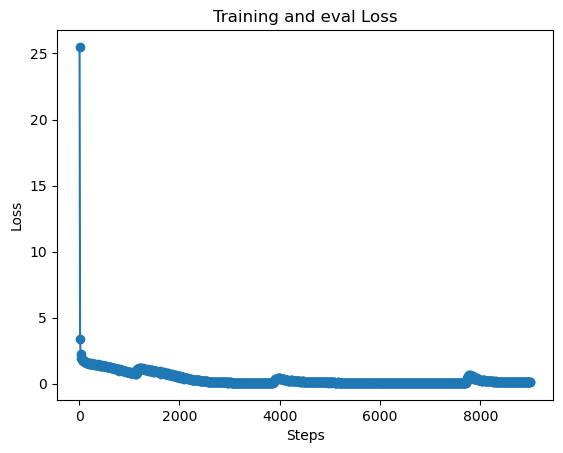

In [106]:
# Drawing the loss plot

import json
import matplotlib.pyplot as plt

# Step 1: Open and load the JSON file
with open("/home/u111169/wrkdir/mgh-project/checkpoints/druggpt2/checkpoint-9000/trainer_state.json", "r") as json_file:
    json_data = json.load(json_file)

data = json_data["log_history"]



# Extract steps and losses from the data
steps = [entry["step"] for entry in data if "step" in entry and "loss" in entry]
# steps_ev = [step for step in steps if step % 20 == 0]
losses_t = [entry["loss"] for entry in data if "step" in entry and "loss" in entry]
# losses_e = [entry["eval_loss"] for entry in data if "step" in entry and "eval_loss" in entry]
# Create a line plot
plt.plot(steps, losses_t, marker="o")
# plt.plot(steps_ev, losses_e, marker="o")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and eval Loss")

plt.savefig("plot.png", bbox_inches="tight")
# Display the plot
plt.show()

In [10]:
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained("/home/u111169/wrkdir/mgh-project/checkpoints/druggpt2/checkpoint-9000", is_decoder=True)# ,num_labels=2)
model.to(device)
model.eval()
def preprocess_and_predict(examples):
    inputs = tokenizer(examples['SMILES'], return_tensors='pt', padding=True, truncation = True)
    inputs = inputs.to(device)
    outputs = model(**inputs)
    logits = outputs.logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probs, dim=-1).item()
    predicted_label = tokenizer.decode(predicted_label)

    return {
        'predicted_class': predicted_label,
        'predicted_class_prob': probs
    }
tokenizer.pad_token = tokenizer.eos_token
test = tokenized_test.map(preprocess_and_predict, batch_size=8 , writer_batch_size=8)
results_df = test.to_pandas()

/share/apps/eb/Anaconda3/2023.03-1/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Map:   0%|          | 0/311 [00:00<?, ? examples/s]

In [92]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score

y_true = [1 if i=='<Approved>' else 0 for i in test_df['labels'].tolist() ]
y_pred = [1 if i=='<Approved>' else 0 for i in results_df['predicted_class'].tolist()]

In [93]:
evaluate(y_true ,y_pred )

{'F1 score': 0.7089949156497803,
 'Accuracy': 0.729903536977492,
 'Precision': 0.7265648147595782,
 'Recall': 0.729903536977492,
 'AUC': 0.6620827351040919,
 'Specificity': 0.41964285714285715}

In [94]:
x = [len(tokenizer.tokenize(train_df["SMILES"][i])) for i in range(len(train_df["SMILES"]))]

In [95]:
tokenizer.decode(50257)

'<Approved>'

In [96]:
inputs = tokenizer(tokenized_test['SMILES'][0], return_tensors='pt', padding=True, truncation = True)
inputs = inputs.to(device)
outputs = model(**inputs)

In [97]:
logits = outputs.logits

# Calculate the probabilities for all tokens in the sequence
probs = torch.nn.functional.softmax(logits, dim=-1)

# Get the predicted token IDs for all positions in the sequence
predicted_token_ids = torch.argmax(probs, dim=-1).squeeze()  # Squeeze to remove batch dimension

# Decode the token IDs to get the output sequence
predicted_sequence = tokenizer.decode(predicted_token_ids)

In [98]:
predicted_sequence

'[1ccc(-c2cccc2)c1-(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12<[mr]>001001010000010111000000000000000000000000010000000001100000000100000000010000000000100000000100000000011100000000000110000010100000000000000000000000000000000100000010010000000000011010110000000000100000000000010010000000010000011000000100111110000000010000001001101100000101010000<[lbl]><Approved>'

In [99]:
inputs = tokenizer(tokenized_test['SMILES'][5], return_tensors='pt', padding=True, truncation = True)
inputs = inputs.to(device)
outputs = model(**inputs)

In [100]:
external_d = [
    "Ogsiveo",
    "Agamree",
    "Velsipity",
    "Exxua",
    "Litfulo",
    "Miebo",
    "Veozah",
    "Daybue",
    "Zavzpret",
    "Filspari",
    "Orserdu",
    "Fabhalta",
    "Truqap",
    "Augtyro",
    "Vanflyta",
    "Posluma",
    "Paxlovid",
    "Joenja",
    "Skyclarys",
    "Jaypirca",
    "Lufotrelvir",
    "Zandelisib",
    "Alpelisib",
    "AMG 337",
    "Evobrutinib",
    "Linperlisib",
    "H3B-8800",
    "Gamcemetinib"
]

ex_df = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/processed_data/External/External.csv")
ex_df["Drug Name"][0]="Fabhalta"

filtered_df = ex_df[ex_df['Drug Name'].isin(external_d)].reset_index(drop=True)

# filtered_df.to_csv("filtered_ex.csv" , index=False)

# ex = filtered_df["SMILES"].tolist()
# ex_label = filtered_df["Approval"].tolist()
filtered_df["SMILES"] = filtered_df.apply(lambda row: convert_to_fingerprint_for_eval(row["SMILES"]), axis=1)
filtered_df["Approval"] = filtered_df["Approval"].map(convert_labels)

/tmp/ipykernel_89801/325247098.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_df["Drug Name"][0]="Fabhalta"


In [101]:
filtered_df

,Drug Name,SMILES,Approval
0,Fabhalta,CCOC1CCN(C(C1)C2=CC=C(C=C2)C(=O)O)CC3=C(C=C(C4...,<Approved>
1,Ogsiveo,CCCC(C(=O)NC1=CN(C=N1)C(C)(C)CNCC(C)(C)C)NC2CC...,<Approved>
2,Truqap,C1CN(CCC1(C(=O)NC(CCO)C2=CC=C(C=C2)Cl)N)C3=NC=...,<Approved>
3,Augtyro,CC1CNC(=O)C2=C3N=C(C=CN3N=C2)NC(C4=C(O1)C=CC(=...,<Approved>
4,Agamree,CC1CC2C3CCC4=CC(=O)C=CC4(C3=CCC2(C1(C(=O)CO)O)...,<Approved>
5,Velsipity,C1CCC(C1)C2=C(C=C(C=C2)COC3=CC4=C(C=C3)NC5=C4C...,<Approved>
6,Exxua,CC1(CC(=O)N(C(=O)C1)CCCCN2CCN(CC2)C3=NC=CC=N3)...,<Approved>
7,Vanflyta,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...,<Approved>
8,Litfulo,CC1CCC(CN1C(=O)C=C)NC2=NC=NC3=C2C=CN3<[mr]>001...,<Approved>
9,Posluma,CC(C)(C)[Si](C1=CC=C(C=C1)C(=O)NCC(C(=O)NC(CCC...,<Approved>


In [102]:
dataset_ex = Dataset.from_pandas(filtered_df)
tokenized_ex = dataset_ex.map(tokenize_function)

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [103]:
test = tokenized_ex.map(preprocess_and_predict, batch_size=8 , writer_batch_size=8)
results_df = test.to_pandas()

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [104]:
y_true = results_df["Approval"].tolist()
y_pred = results_df['predicted_class'].tolist()

In [105]:
y_true

['<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<Approved>',
 '<NotApproved>',
 '<NotApproved>',
 '<NotApproved>',
 '<NotApproved>',
 '<NotApproved>',
 '<NotApproved>',
 '<NotApproved>',
 '<NotApproved>']

In [22]:
y_true = [1 if i=='<Approved>' else 0 for i in results_df["Approval"].tolist() ]
y_pred = [1 if i=='<Approved>' else 0 for i in results_df['predicted_class'].tolist()]

In [23]:
evaluate(y_true ,y_pred )

{'F1 score': 0.482051282051282,
 'Accuracy': 0.5,
 'Precision': 0.8181818181818182,
 'Recall': 0.5,
 'AUC': 0.65,
 'Specificity': 1.0}

In [24]:
(y_true ,y_pred )

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])